<a href="https://colab.research.google.com/github/maren11/GitTest/blob/master/Copy_of_TF2_Classification_Aufgaben.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF2 Übungsaufgaben zur Klassifikation

1. Bibliotheken importieren

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from  tensorflow.keras import layers

# Sie benötigen außerdem:
# tensorflow (tf), tensorflow_datasets (tfds)

# Sowie aus dem tensorflow package die Pakete keras und keras.layers

2. Bilder herunterladen

In [ ]:
dataset_name = "cats_vs_dogs"

In [ ]:
train_ds, validation_ds, test_ds = tfds.load(
    dataset_name,
    split=["train[:80%]", "train[80%:90%]", "train[90%:100%]"],
    as_supervised=True,
)

print("Trainingsbilder: %d" % tf.data.experimental.cardinality(train_ds))
print("Validierungsbilder: %d" % tf.data.experimental.cardinality(validation_ds))
print("Testbilder: %d" % tf.data.experimental.cardinality(test_ds))

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteJT9XP9/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Trainingsbilder: 18610
Validierungsbilder: 2326
Testbilder: 2326


3. Einen Blick auf die Daten werfen

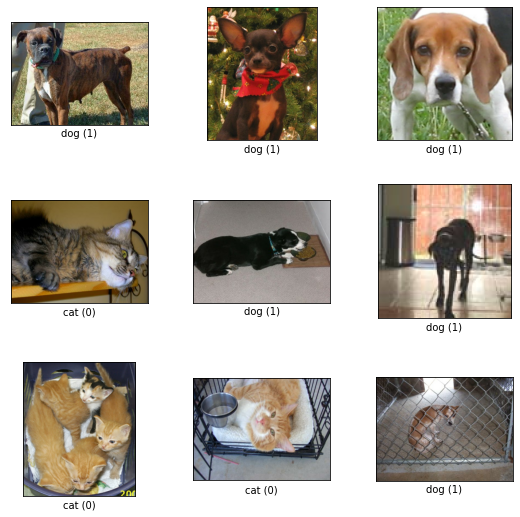

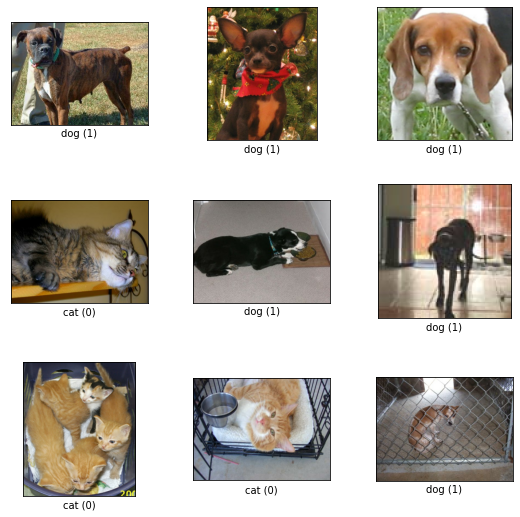

In [ ]:
ds, ds_info = tfds.load(dataset_name,split="train", with_info=True)
tfds.show_examples(ds_info, ds)

4. Input vorverarbeiten

In [ ]:
# Helferfunktion zum Skalieren eines Datensatzes auf eine gewünschte Bildgröße
def resize_ds(ds, size):
  return ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [ ]:
# Helferfunktion zum Unterteilen eines Datensatzes in Batches einer gewünschten Größe
def batch_ds(ds, batch_size):
  return ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [ ]:
# Skalieren Sie die heruntergeladenen Bilder auf eine Größe von 150 x 150 (als Python Tupel)
# Ersetzen sie 'None' durch die entsprechenden Werte und Aufrufe

size = (150,150)

train_ds = resize_ds(train_ds,size)
validation_ds =resize_ds(validation_ds,size)
test_ds = resize_ds(test_ds,size)


In [ ]:
# Teilen sie die Datensätze in Batches auf. Experimentieren Sie mit der Größe bezüglich Trainingsdauer und Ergebnis

batch_size = 32

train_ds = batch_ds(train_ds,batch_size)
validation_ds = batch_ds(validation_ds,batch_size)
test_ds = batch_ds(test_ds,batch_size)


5. Data Augmentation Strategien definieren

In [ ]:
# Erstellen Sie eine Liste von Augmentierungen. Suchen Sie diverse geeignete Transformationen heraus,
# mindestends aber eine horizontale Spiegelung und eine Rotation
# Die Funktionen finden Sie unter layers.experimental.preprocessing

data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.1),

     

    
    ]
)

In [ ]:
# Diese Funktion stellt Beispiele der Augmentierungen dar
def show_augmentations():
  for images, labels in train_ds.take(2):
      plt.figure(figsize=(10, 10))
      first_image = images[0]
      for i in range(9):
          ax = plt.subplot(3, 3, i + 1)
          augmented_image = data_augmentation(
              tf.expand_dims(first_image, 0), training=True
          )
          plt.imshow(augmented_image[0].numpy().astype("int32"))
          plt.axis("off")

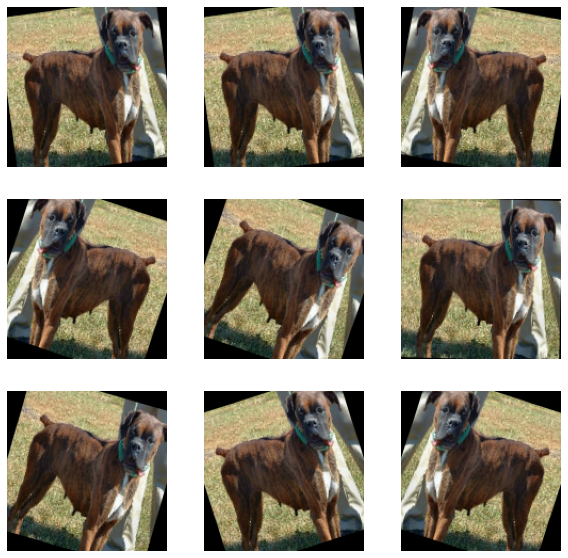

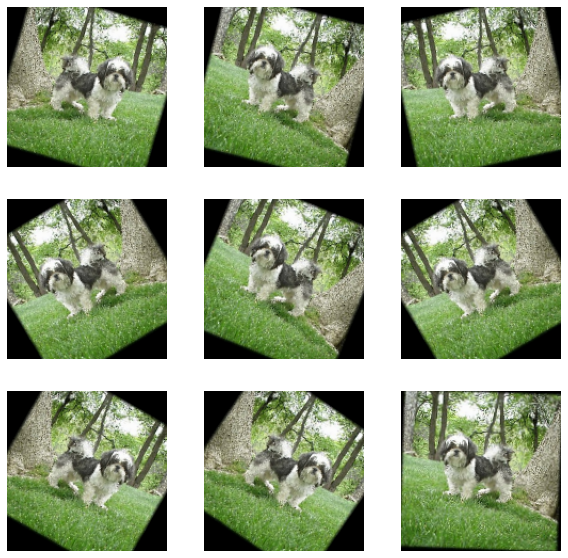

In [ ]:
show_augmentations()

6. CNN definieren: Xception Netzwerk mit neuem "Kopf" zum Fine-Tuning

In [ ]:
def build_model():

  # Definieren Sie das Basis-Modell:
  # Nutzen Sie vortrainierte Gewichte von "imagenet" und wählen Sie eine passende Input-Größe (Channels beachten)

  input_shape=(150,150,3)
  weights="imagenet" # Vortrainierte ImageNet-Gewichte.

  base_model = keras.applications.Xception(
      weights=weights,
      input_shape=input_shape,
      include_top=False,
  )

  # Basis-Model nicht mittrainieren
  base_model.trainable = False

  # Angepassten Input erstellen:
  inputs = keras.Input(shape=input_shape)

  # Zufällige Augmentation durchführen
  x = data_augmentation(inputs)

  # Input normalisieren
  norm_layer = keras.layers.experimental.preprocessing.Normalization()
  mean = np.array([127.5] * 3)
  var = mean ** 2
  x = norm_layer(x)
  norm_layer.set_weights([mean, var])

  # Xception Netzwerk an neuen Input anhängen:
  x = base_model(x, training=False)

  # definieren Sie den Output des Modells selbst:
  # Fügen sie ein GlobalAveragePooling2D, ein Dropout (20%) und einen Dense-Layer mit einem Output-Neuron ein
  # Die Layer finden Sie in keras.layers


  x = keras.layers.GlobalAveragePooling2D()(x) # Pooling zur Verkleinerung
  x = keras.layers.Dropout(0.2)(x)  # Dropout gegen Overfitting
  outputs = keras.layers.Dense(1)(x) # Fully-Connected Output
  
  return keras.Model(inputs, outputs)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model = build_model()

83689472/83683744 [==============================] - 1s 0us/step


7. Trainingsparameter festlegen

In [ ]:
# Definieren Sie ein geeignetes Optimierungsverfahren und experimentieren Sie ggf. mit verschiedenen
# Finden Sie eine geeignete Fehlerfunktion sowie Metrik für ein binäres Klassifikationsverfahren



model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

8. Trainieren

In [ ]:
epochs = 5
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/5
582/582 [==============================] - 110s 190ms/step - loss: 0.1635 - binary_accuracy: 0.9270 - val_loss: 0.0912 - val_binary_accuracy: 0.9686
Epoch 2/5
582/582 [==============================] - 100s 173ms/step - loss: 0.1319 - binary_accuracy: 0.9438 - val_loss: 0.0995 - val_binary_accuracy: 0.9665
Epoch 3/5
582/582 [==============================] - 101s 173ms/step - loss: 0.1265 - binary_accuracy: 0.9463 - val_loss: 0.0851 - val_binary_accuracy: 0.9738
Epoch 4/5
582/582 [==============================] - 101s 173ms/step - loss: 0.1238 - binary_accuracy: 0.9485 - val_loss: 0.0793 - val_binary_accuracy: 0.9733
Epoch 5/5
582/582 [==============================] - 101s 173ms/step - loss: 0.1191 - binary_accuracy: 0.9500 - val_loss: 0.0937 - val_binary_accuracy: 0.9682


9. Modell manuell auf Testdaten evaluieren

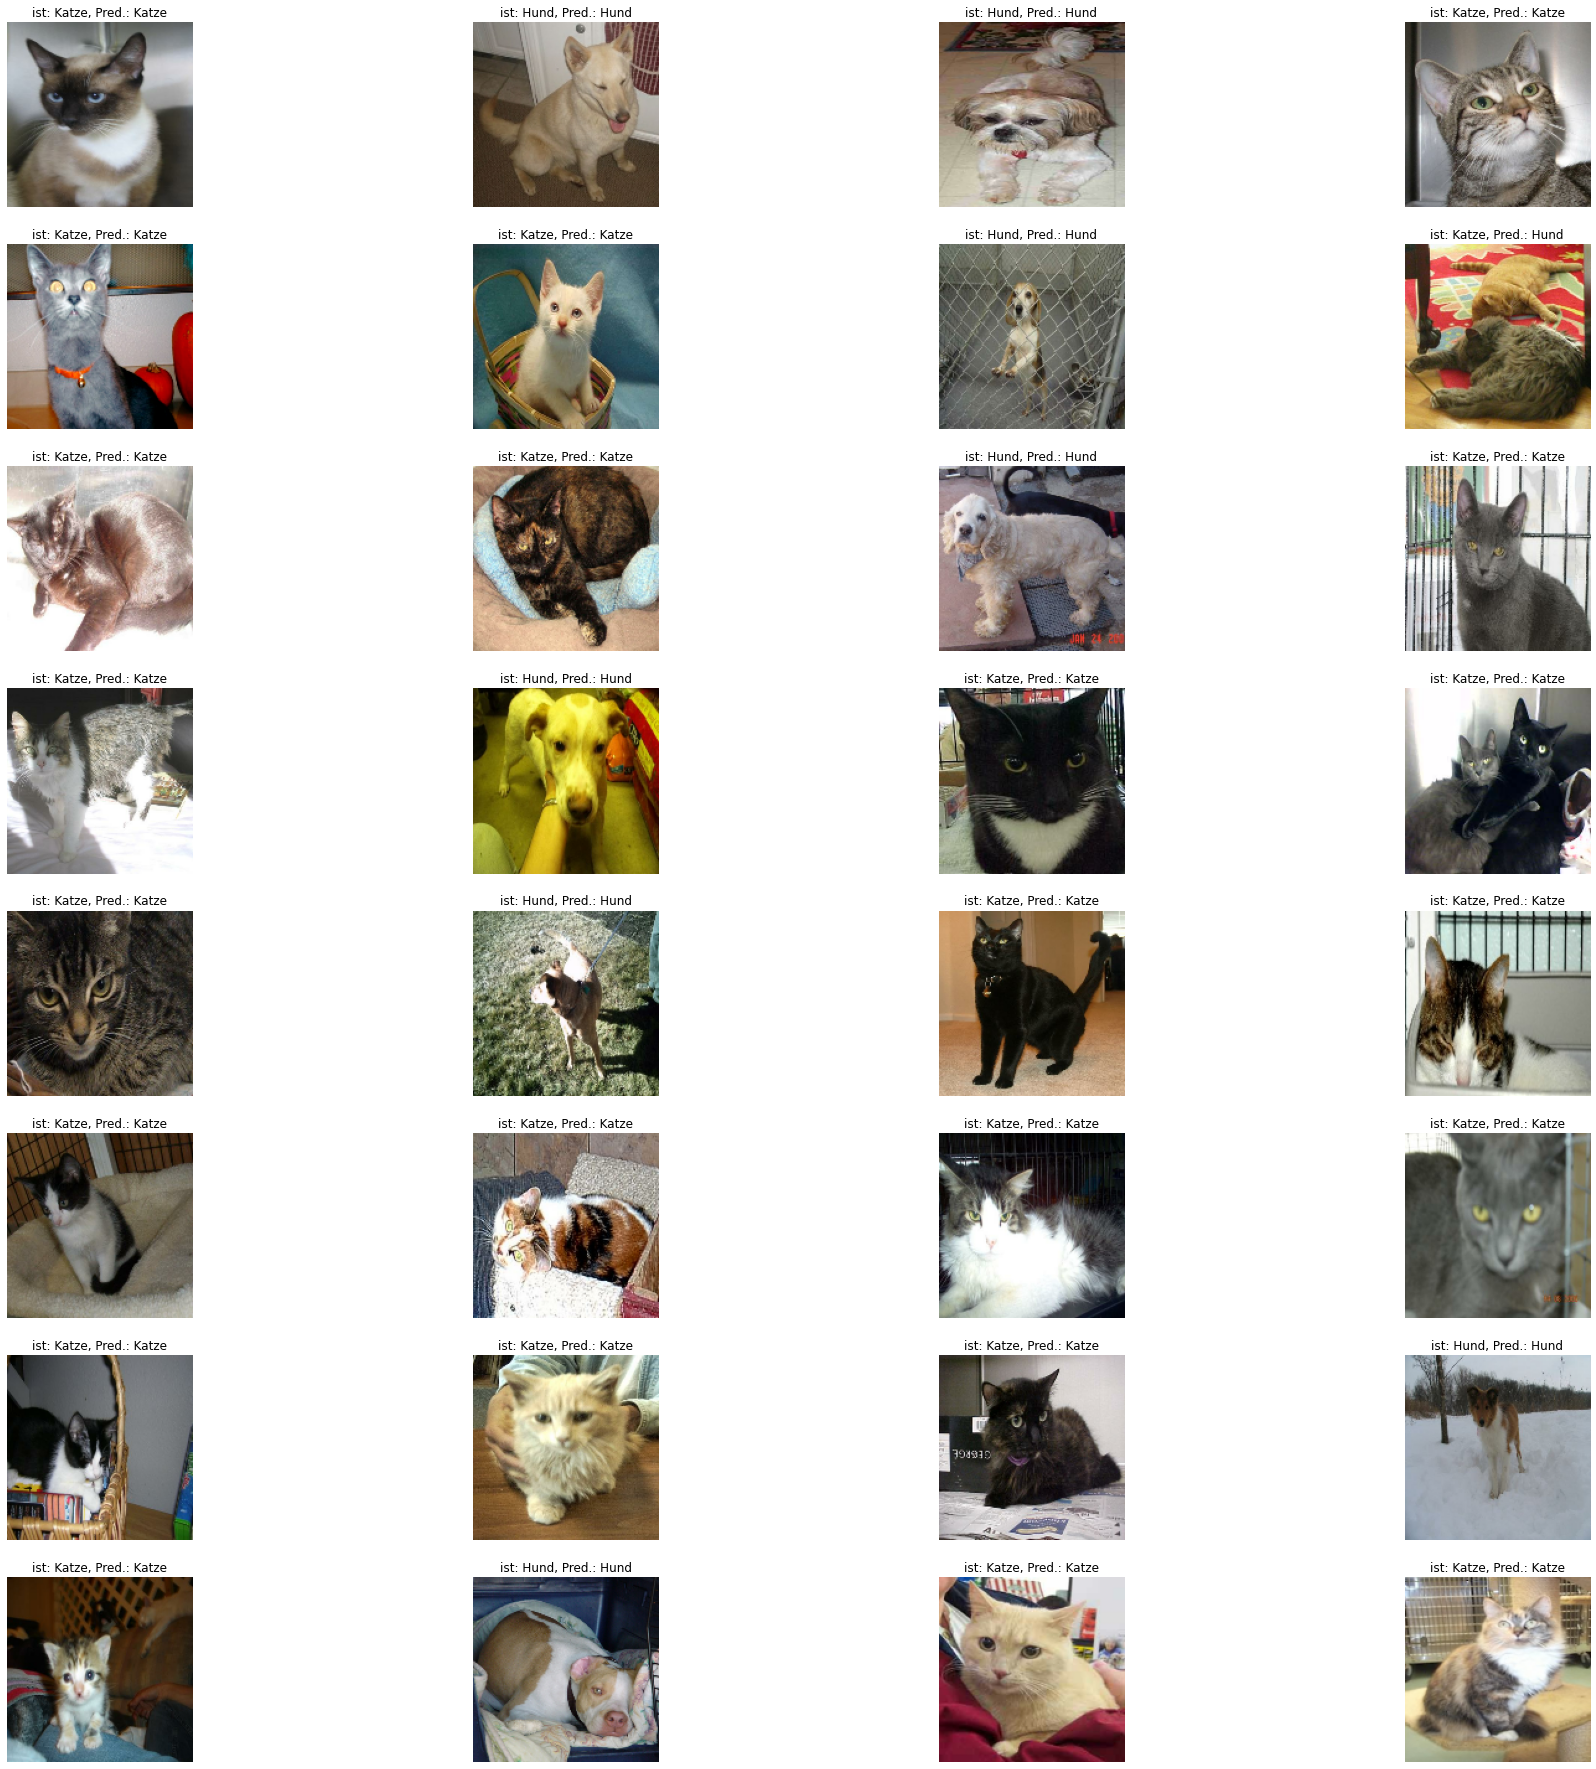

In [ ]:
for images, labels in test_ds.take(1): # 1 batch mit 32 Bildern nehmen
  plt.figure(figsize=(32, 32))
  i = 0
  for image, label in zip(images, labels):
    prediction = model.predict(tf.expand_dims(image, 0))
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(images[i].numpy().astype("int32"))

    is_label = 'Katze' if int(label) == 0 else 'Hund'
    pred_label = 'Katze' if prediction[0][0] < 0 else 'Hund'

    plt.title(f'ist: {is_label}, Pred.: {pred_label}')
    plt.axis("off")
    i += 1